<a href="https://colab.research.google.com/github/Martinmbiro/machakos-flood-detection-2024/blob/main/Machakos_flood_detection_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ⚠️ **Note**
+ For the Earth Engine python API, `ee` to work, you should have registed for an Earth Engine project; which you can do [here](https://earthengine.google.com/signup/)
+ Once registered, you have the option to choose the non-commercial option.
+ Pass the Earth Engine project ID to `ee.Initialize(project=your_ee_project_id)` to initialize your project
+ Also, make sure to use the **same** email for both this Colab notebook and your Earth Engine project

In [ ]:
# install rasterio
!pip install rasterio

In [2]:
# imports
import geemap, ee
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, matplotlib.colors as mcolors, geopandas as gpd
import requests, pathlib

import rasterio, rasterio.plot as rplot
from rasterio.warp import calculate_default_transform, reproject, Resampling

from google.colab import userdata, drive

# authenticate and initialize earth engine project
ee.Authenticate()
ee.Initialize(project=userdata.get('PROJECT_ID'))

In [3]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define helper functions
> Below, I define a few helper and mapped functions

In [4]:
# mapped function to add water index bands and mask out cloudy pixels
def mask_add_bands(img:ee.Image):
    # select bands from Sentinel-2:
    # green(B3), Short Wave Infra Red 1 (SWIR 1), The Scene Classification Layer (SCL)
    image = img.select(['B3', 'B11', 'SCL'])

    # --- Compute water index ---
    mndwi  = image.normalizedDifference(['B3', 'B11'])

    # --- Make an MNDWI mask with a threshold of -0.05
    mndwi_mask = mndwi.updateMask(mndwi.gte(-0.05)).rename('MNDWI_mask')

    # ------ Cloud Masking -----
    # bad classes -> 3-Cloud shadow, 8-Cloud medium prob, 9-Cloud high prob, 10-Cirrus, 11-Snow
    bad_classes = [3, 8, 9, 10, 11]
    cloud_mask = image.remap(bad_classes, [0]*len(bad_classes), 1, 'SCL')

    # Add all to image
    return (image
                .addBands(mndwi_mask)
                .addBands(mndwi)
                .updateMask(cloud_mask)
                .set('month', image.date().format('YYYY-MM')))

# mapped function to perform monthly composites and reduce Images by region
def composite_monthly(month):
  # filter ImageCollection by month property
  filtered_collection = s2_col.filter(ee.Filter.eq(name='month', value=month))

  # composite collection by medium pixel value across all bands
  image = filtered_collection.median().set('month', month)

  # reduce region on image, and calculate value of non-null pixels
  # (useful for calculating the no. of water pixels in MNDWI_mask band)
  stats = image.reduceRegion(reducer=ee.Reducer.count(),
                             geometry=machakos,
                             scale=10,
                             maxPixels=1e10) # returns a dict, whose keys are band names
                                             # & values are statistical values,
                                             # median in this case

  # set the pixel_count as an image property and return the image
  return image.set('pixel_count', stats.get('MNDWI_mask'))
              # .addBands(mndwi_mask)
              # .set('mean_mndwi', st2.get('MNDWI'))

# mapped function to blend MNDWI_mask with a white background
def get_blended_col(img):
  img = ee.Image(img).select('MNDWI_mask')
  vis_params = {'min':-1,'max':1,'palette':['ffffff', '00009c']} # mask pixel visualization

  # gray_base = (ee.FeatureCollection(machakos.geometry().buffer(5000).bounds())
  #               .style(color=None, width=None, fillColor='000000')) # -> ee.Image
  white_base = machakos.style(color='black', width=3, fillColor='ffffff') # -> ee.Image

  # return (gray_base.blend(white_base).blend(img.visualize(**vis_params)))
  return white_base.blend(img.visualize(**vis_params))

# function to download the Kenyan counties vector dataset
def download_counties_data():
  # raw link to the counties.geojson file on my github repository:
  raw_url = 'https://github.com/Martinmbiro/machakos-flood-detection-2024/raw/refs/heads/main/data/counties.geojson'

  # make a get request
  r = requests.get(url=raw_url, stream=True)

  if r.status_code == 200: # successful request
    # define path for dowload file
    geo_file = pathlib.Path.cwd().joinpath('counties.geojson')

    # open file and write to it using the get request's content
    with geo_file.open(mode='wb') as f:
      for chunk in r.iter_content(chunk_size=100):
        f.write(chunk)

      print(f'Downloaded to: {geo_file}')
  else:
    print('Something went wrong\nCheck the link again')

# function to display gif generated by getVideThumbURL
def download_display_gif(url:str, filename:str):
  r = requests.get(url=url, stream=True)

  if r.status_code == 200:
    gif_file = pathlib.Path.cwd().joinpath(f'{filename}.gif')

    with gif_file.open(mode='wb') as f:
      for chunk in r.iter_content(chunk_size=300):
        f.write(chunk)

    print(f'March -> April -> May -> June -> August\n')
    # show image
    geemap.show_image('/content/machakos.gif', width=300, height=300)
    print(f'Path: {gif_file}\n')

  else:
    print('Request not honoured')

# function to reproject raster file into ESPG:4326
def reproject_raster(source_file, dest_file):
  # refer to: https://py.geocompx.org/06-reproj#sec-reprojecting-vector-geometries

  # Define the destination CRS
  dst_crs = 'EPSG:4326'

  # Path to your source raster file (the one currently in meters)
  source_file = source_file
  # Path for the new, reprojected raster file
  dest_file = dest_file

  # Open the source raster file
  with rasterio.open(source_file) as src:
      # Calculate the new transform, width, and height for the destination CRS
      transform, width, height = calculate_default_transform(
          src.crs, dst_crs, src.width, src.height, *src.bounds
      )

      # Get the metadata from the source file
      kwargs = src.meta.copy()

      # Update the metadata with the new CRS, transform, and dimensions
      kwargs.update({
          'crs': dst_crs,
          'transform': transform,
          'width': width,
          'height': height
      })

      # Create the new raster file and write the reprojected data
      with rasterio.open(dest_file, 'w', **kwargs) as dst:
          # Reproject each band of the raster
          for i in range(1, src.count + 1):
              reproject(
                  source=rasterio.band(src, i),
                  destination=rasterio.band(dst, i),
                  src_transform=src.transform,
                  src_crs=src.crs,
                  dst_transform=transform,
                  dst_crs=dst_crs,
                  resampling=Resampling.nearest  # Or a different method like bilinear
              )

## Retrieve remote sensing data
> This section is about Geospatial data acquisition and processing


### Get our region of interest - Machakos county
+ First, download the vector dataset containing Kenyan counties' geo-boundaries. This is handled by the helper function `download_counties_data`
+ [`geemap.geojson_to_ee`](https://geemap.org/usage/) converts a `*.gejson` file to an [`ee.FeatureCollection`](https://developers.google.com/earth-engine/apidocs/ee-featurecollection) that we can then [`filter`](https://developers.google.com/earth-engine/apidocs/ee-featurecollection-filter) for `Machakos`
+ The `ee.FeatureCollection` returned can then be passed to the [`filterBounds`](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-filterbounds) function of an [`ee.ImageCollection`](https://developers.google.com/earth-engine/apidocs/ee-imagecollection)

In [5]:
# download the geojson file containing geo-boundaries
download_counties_data()

Downloaded to: /content/counties.geojson


In [6]:
# get the FeatureCollection for Machakos county
machakos = (geemap.geojson_to_ee('/content/counties.geojson')
            .filter(ee.Filter.eq(name='county', value='Machakos'))) # -> FeatureCollection

### Get [Sentinel2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) data as an [`ee.ImageCollection`](https://developers.google.com/earth-engine/apidocs/ee-imagecollection)
> ⏬ **Procedure**
>+ Get Sentinel2 data as an `ee.ImageCollection`
>+ Filter the collection by date, from `2024-01-01` inclusive to `2025-01-01` exclusive
>+ Filter by region of interest, in this case `machakos` county as an `ee.FeatureCollection`
>+ For each `ee.Image` in the `ee.ImageCollection`, add an `MNDWI_mask` band, a cloud mask, and a `month` property. The `mask_add_bands` function defined above takes care of this logic

In [7]:
%%time
# get the Sentinel2 surface reflectance data
s2_col = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
            .filterDate(start='2024-01-01', end='2025-01-01')
            # .filter('CLOUDY_PIXEL_PERCENTAGE < 20')
            .filterBounds(machakos)
            .map(mask_add_bands))

# size of collection
print(f's2_col size: {s2_col.size().getInfo()}\n')

s2_col size: 288

CPU times: user 871 ms, sys: 22.7 ms, total: 894 ms
Wall time: 6.77 s


### Get all `months` from the Sentinel `ImageCollection` as an [`ee.list`](https://developers.google.com/earth-engine/apidocs/ee-list)
> ⏬ **Procedure**
>+ Aggregate over the `month` property of the `ee.Image` objects in the Sentinel2 `ImageCollection`, returning an [`ee.List`](https://developers.google.com/earth-engine/apidocs/ee-list) of all the values of the `month` property; by calling[`ImageCollection.aggregate_array`](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-aggregate_array)
>+ Remove duplicates from the returned `ee.List` by calling [`ee.List.distinct`](https://developers.google.com/earth-engine/apidocs/ee-list-distinct)
>+ Sort the `ee.List` in ascending order _(Jan - Dec)_ by calling [`ee.List.sort`](https://developers.google.com/earth-engine/apidocs/ee-list-sort)
>+ Retrieve the values from the `ee.List` as a python list by calling [`ee.List.getInfo`](https://developers.google.com/earth-engine/apidocs/ee-list-getinfo)

In [8]:
# get month values from s2_col, remove duplicates, sort
months = s2_col.aggregate_array(property='month').distinct().sort() # -> ee.List

# create a python list from the ee.List
month_list = months.getInfo()

### Get an [`ee.List`](https://developers.google.com/earth-engine/apidocs/ee-list) of monthly `ee.Image` composites from the Sentinel2 `ImageCollection`
> ⏬ **Procedure**
>+ Group the Sentinel2 `ImageCollection` by each `month` in `months`, then composite by `median`. In statistics, _median_ is robust to outliers
>+ For each composite `ee.Image`, aggregate pixel values for `MNDWI_mask` band within `machakos` county by [`count`](https://developers.google.com/earth-engine/apidocs/ee-reducer-count), then add this `pixel_count` value as an [`ee.Image`](https://developers.google.com/earth-engine/apidocs/ee-image) property
>+ This logic is handled by the `composite_monthly` function defined above

In [9]:
# map over each month, and create an ee.List of monthly composites
s2_comp_ls = months.map(composite_monthly) # -> ee.List

### Get all `pixel_count` values from the  [`ee.List`](https://developers.google.com/earth-engine/apidocs/ee-list) of monthly composite `ee.Image`s
> ⏬ **Procedure**
>+ Get an `ImageCollection` from the `s2_comp_ls` `ee.List` of composite `ee.Image`s
>+ Aggregate over the `pixel_count` property of the `ee.Image` objects in the `ImageCollection`, returning an [`ee.List`](https://developers.google.com/earth-engine/apidocs/ee-list) of all the values of the `pixel_count` property; by calling[`ImageCollection.aggregate_array`](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-aggregate_array)
>+ Retrieve the values from the `ee.List` as a python list by calling [`ee.List.getInfo`](https://developers.google.com/earth-engine/apidocs/ee-list-getinfo)

In [10]:
%%time
pixel_count = (ee.ImageCollection.fromImages(s2_comp_ls)
                .aggregate_array(property='pixel_count')
                .getInfo()) # ee.List -> python list

CPU times: user 658 ms, sys: 169 ms, total: 827 ms
Wall time: 1min 3s


## Visualize time series
> ⏬ **Procedure**
>+ Using [`pandas`](https://pandas.pydata.org/docs/index.html), create a [`DataFrame`](https://pandas.pydata.org/docs/reference/frame.html#dataframe) from the `month_list` and `pixel_count` python `lists` derived from the previous section of the notebook
>+ Convert the `month` column of the `DataFrame` into a `datetime` object, then extract the month name. See guide linked [here](https://pandas.pydata.org/docs/user_guide/timeseries.html#time-date-components)
>+ Add a new column, `water_area` derived from `pixel_count` and Sentinel2 spatial resolution (`1` pixel = `10` metres by `10` metres)
>+ Create a [`seaborn.lineplot`](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn-lineplot) using the `DataFrame`

In [11]:
# make a DataFrame from months list and mean_mndwi list
data = pd.DataFrame({'month': month_list, 'pixel_count': pixel_count})

# convert the month column into a datetime object
data['month'] = pd.to_datetime(data['month'])
# have the date column display month names
data['month'] = data['month'].dt.month_name()

# compute water area from pixel_count and the area of one Sentinel2 pixel
# 1 pixel = (10 * 10)m^2; m^2 -> km^2, multiply by 1e-6
data['water_area'] = data['pixel_count'].apply(lambda x: x*((10 * 10) * 1e-6))

In [12]:
# display the dataframe
data

,month,pixel_count,water_area
0,January,1842284,184.2284
1,February,1265585,126.5585
2,March,974211,97.4211
3,April,1678885,167.8885
4,May,2004664,200.4664
5,June,1274347,127.4347
6,July,1059646,105.9646
7,August,835853,83.5853
8,September,954477,95.4477
9,October,908064,90.8064


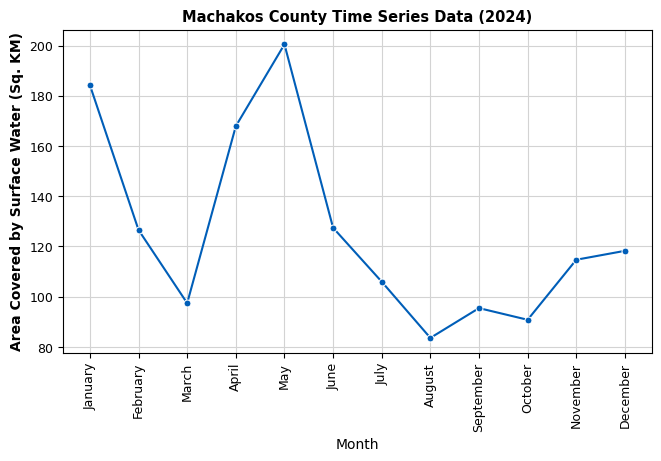

In [13]:
# plot time series of area occupied by surface water
f, ax = plt.subplots(figsize=(6.5, 4.5), layout='compressed')
ax.set_title('Machakos County Time Series Data (2024)', fontsize=10.5, weight='black')
ax.set_ylabel('Area Covered by Surface Water (Sq. KM)', fontsize=10, weight='black')
ax.set_xlabel('Month', fontsize=10)
ax.tick_params(axis='x', labelsize=9, labelrotation=90)
ax.tick_params(axis='y', labelsize=9)
ax.grid(color='lightgray')

sns.lineplot(data=data, y='water_area', x='month',
             color='#005eb8', marker='o', markersize=5, ax=ax)
plt.show()

> 📈 **Analysis**
+ _May_ recorded the largest area occupied by surface water, meaning that most flash floods occured in this month and/or major water bodies broke their banks
+ _January's_ significant surface water area was possibly due to the fact that long rains started in late 2023 and proceeded to _January_ of 2024
+ Our focus, however, is on the flash-flood months: _March, April, May_

## Visualize Images
> Here, we'll visualize the `ee.Image` objects on a `geemap.Map`, and using good old `matplotlib.pyplot`

### Using [`geemap.Map`](https://geemap.org/core/#geemap.core.Map)  
> `geemap.Map` allows us to create interactive maps

> ⏬ **Procedure**
>+ Get the specific month's composite `ee.Image` from the `ee.List` of composite images
>+ Select the `MNDWI_mask` band from that `ee.Image`, then visualize the band using `geemap.Map`

In [14]:
# get image for Jan, April, May, June, August from the list of composite images
march_img = ee.Image(s2_comp_ls.get(2)).select('MNDWI_mask')
april_img = ee.Image(s2_comp_ls.get(3)).select('MNDWI_mask')
may_img = ee.Image(s2_comp_ls.get(4)).select('MNDWI_mask')
june_img = ee.Image(s2_comp_ls.get(5)).select('MNDWI_mask')

aug_img = ee.Image(s2_comp_ls.get(7)).select('MNDWI_mask')

#### Visualize one `Image` at a time
> `ee.Image`s can be added as layers to the map to visualize them using [`add_layer`](https://geemap.org/core/#geemap.core.Map.add_layer)

> ✋ **Info**
+ **Machakos** layer is semi-transparent so you can see through to the map below
+ The blue patches on **MNDWI mask** layer represent water pixels
+ The most prominent water bodies in Machakos county are the _Masinga Reservoir_, _Thika River_ and _Athi River_ - the rest of the scattered blue patches likely represent flash floods
+ You can zoom in as much as you want to clearly see where the water pixels lie on the map


In [ ]:
# create a geemap.Map object centering it at Machakos -> County 1.32S, 37.27E
map = geemap.Map(center=[-1.32, 37.27], zoom=10.4) # machakos county

vis_params = {'min':-1,'max':1,'palette':['ffffff', '005eb8']}
feat_params= {'color':'black', 'width':1.5, 'fillColor': 'e5e4e298'} # geometry style parameters

# add Machakos FeatureCollection & desired ee.Image to map as layers
map.add_layer(machakos.style(**feat_params), None, 'Machakos')
map.add_layer(ee_object=may_img.clip(machakos), # composite ee.Image for May
                        vis_params=vis_params,
                        name='MNDWI mask')

# display the map with added layers
display(map)

Map(center=[-1.32, 37.27], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

#### Visualizing two `Image` side by side
> Two `ee.Image`s can be displayed side by side on a split panel map with a slider
+ First, declare two `geemap.ee_tile_layer` objects and pass the desired `ee.Image`s
+ Then pass the objects to `Map.split_map()`; one as the `right_layer` and the second as the `left_layer`. See guide linked [here](https://courses.geemap.org/geemap_intro/09_split_map/)

> 🔔 **Info**
>+ For this split panel map, I have displayed composite `MNDWI_mask` for the month of _May_ that recorded the highest area in surface water, and _August_ that recorded the least area of surface water. Maybe try displaying _April_ and _May_ side by side to see how the floods progressed over the course of one month
>+ This way, you can visualize how conditions for the same region changed over time

In [ ]:
# create a geemap.Map object centering it at Machakos -> County 1.32S, 37.27E
map = geemap.Map(center=[-1.32, 37.27], zoom=10.4) # machakos county
map.add_layer(machakos.style(**feat_params), {}, 'Machakos') # transparent layer over Machakos

aug_layer = geemap.ee_tile_layer(
    ee_object=aug_img.clip(machakos),
    vis_params=vis_params,
    name='April MNDWI Mask')

may_layer = geemap.ee_tile_layer(
    ee_object=may_img.clip(machakos),
    vis_params=vis_params,
    name='May MNDWI Mask')

# split the map
map.split_map(left_layer=aug_layer, right_layer=may_layer)

display(map)

Map(center=[-1.32, 37.27], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

#### Visualize monthly timelapse
> Here, I'll create a timelapse gif file for the months of _March, April, May, June,_ and _August_
+ The blue patches represent water pixels
+ The white polygon represents the geographical boundary for Machakos Country

> ⏬ **Procedure**
>+ First, paint the `MNDWI_mask` band from the above months on a white background. This logic is handled by the mapped function `get_blended_col`
>+ Then call `ImageCollection.getVideoThumbURL` to generate a url for an animated gif of the `ImageCollection`
>+ Finally, download the gif and display it. This is handled by the `download_display_gif` helper function

In [15]:
# make an ImageCollection of March, April, May, June & August MNDWI_mask bands
# then paint the band on a white background for each
blended_col = (ee.ImageCollection([march_img, april_img, may_img, june_img, aug_img])
                .map(get_blended_col))

In [16]:
%%time
# define gif parameters
gifParams = {
  'region': machakos.geometry().buffer(5000),
  'dimensions': 1600,
  'crs': 'EPSG:4326',
  'framesPerSecond': 1
}

# return the url for the gif
url = blended_col.getVideoThumbURL(gifParams)

CPU times: user 1.42 s, sys: 16.7 ms, total: 1.44 s
Wall time: 1min 9s


In [ ]:
%%time
# download and display gif from url
download_display_gif(url=url, filename='machakos')

### Using `matplotlib`
> `matplotlib` will display the `ee.Image` rasters as **static** plots

> ⏬ **Procedure**

> To plot the `ee.Image` using `matplotlib`, we'll have to follow a few steps
>+ Export the `ee.Image` we want (composite `ee.Image` for April, May, June) as `geotiff` format.
>+ Reprojected the generated raster files into a Geographic Reference System (`EPSG:4326`)
>+ Read the raster files using [`rasterio`]() and vector data using [`geoapandas`](), then plot them on the same subplots

#### Export specific `ee.Image` as raster files
> The [user guide](https://developers.google.com/earth-engine/guides/exporting_images#colab-python) explains how to export the Images into google drive, which is what I'll be doing here

In [ ]:
exp_params = {'min':-1,'max':1}

# define the tasks
task1 = ee.batch.Export.image.toDrive(
    image=april_img.select('MNDWI_mask').visualize(**exp_params),
    description='April2024MNDWI',
    folder='GEE Rasters', # a folder on your Google Drive
    scale=50,
    region=machakos.geometry().buffer(5000).bounds(),
    crs='EPSG:4326',
    fileFormat='GeoTIFF',
    maxPixels=1e9)

task2 = ee.batch.Export.image.toDrive(
    image=may_img.select('MNDWI_mask').visualize(**exp_params),
    description='May2024MNDWI',
    folder='GEE Rasters',
    scale=50,
    region=machakos.geometry().buffer(5000).bounds(),
    crs='EPSG:4326',
    fileFormat='GeoTIFF',
    maxPixels=1e9)

task3 = ee.batch.Export.image.toDrive(
    image=june_img.select('MNDWI_mask').visualize(**exp_params),
    description='June2024MNDWI',
    folder='GEE Rasters',
    scale=50,
    region=machakos.geometry().buffer(5000).bounds(),
    crs='EPSG:4326',
    fileFormat='GeoTIFF',
    maxPixels=1e9)

task4 = ee.batch.Export.image.toDrive(
    image=aug_img.select('MNDWI_mask').visualize(**exp_params),
    description='August2024MNDWI',
    folder='GEE Rasters',
    scale=50,
    region=machakos.geometry().buffer(5000).bounds(),
    crs='EPSG:4326',
    fileFormat='GeoTIFF',
    maxPixels=1e9)

# initiate export tasks
task1.start()
task2.start()
task3.start()
task4.start()

In [ ]:
# check the task's status
task1.status()

{'state': 'COMPLETED',
 'description': 'April2024MNDWI',
 'priority': 100,
 'creation_timestamp_ms': 1757143725555,
 'update_timestamp_ms': 1757144308495,
 'start_timestamp_ms': 1757143732961,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/17XlevzmPZJmINLFNXDorIiSM5ETLaIz1'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 356.37286376953125,
 'id': '3OGRIIRDB5KX6REHZVPPQ7VB',
 'name': 'projects/gee101-470407/operations/3OGRIIRDB5KX6REHZVPPQ7VB'}

#### Reproject the raster files
> I'll use the `reproject_raster` function that I'd defined at the start of the notebook. Refer [here](https://py.geocompx.org/06-reproj#sec-reprojecting-raster-geometries) for how the function works

In [ ]:
# reproject generated rasters to EPSG:4326: a Geographic Reference System
reproject_raster(
    source_file='/content/drive/MyDrive/GEE Rasters/April2024MNDWI.tif',
    dest_file='/content/april.tif')

reproject_raster(
    source_file='/content/drive/MyDrive/GEE Rasters/May2024MNDWI.tif',
    dest_file='/content/may.tif')

reproject_raster(
    source_file='/content/drive/MyDrive/GEE Rasters/June2024MNDWI.tif',
    dest_file='/content/june.tif')

reproject_raster(
    source_file='/content/drive/MyDrive/GEE Rasters/August2024MNDWI.tif',
    dest_file='/content/aug.tif')

#### Read in rasters & vector data
+ Read in the raster files (`*.tif`) using [`rasterio`](https://rasterio.readthedocs.io/en/stable/index.html)
+ Read in the `counties.geojson` vector dataset, then filter for _Machakos_ county using [`geopandas`](https://geopandas.org/en/v1.1.0/index.html)


In [ ]:
# read the rasters
april = june = rasterio.open('/content/april.tif')
may = rasterio.open('/content/may.tif')
june = rasterio.open('/content/june.tif')
aug = rasterio.open('/content/aug.tif')

# filter out Machakos county vector
counties = gpd.read_file('/content/counties.geojson') #GoeDataFrame
mks = counties[counties['county']=='Machakos']

#### Plotting
+ Declare subplots, and plot the raster & vector data on the respective plots
+ Plotting the images side by side will help us visualize the trend

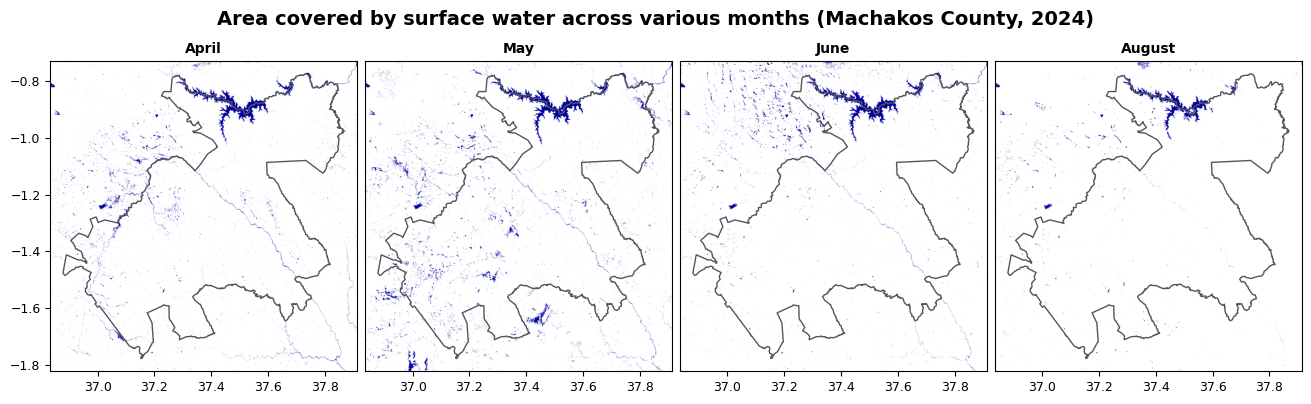

In [ ]:
# define a custom color map (white -> blue)
# white signifiy low MNDWI values; blue signify high MNDWI values             #005eb8
c_cmap = mcolors.LinearSegmentedColormap.from_list('white_blue', ['#ffffff', '#00009c'])

# declare and set up subplots
f, axs = plt.subplots(1, 4, figsize=(13,13), layout='compressed')
axs[0].tick_params(axis='both', labelsize=9)
axs[1].tick_params(axis='both', labelsize=9)
axs[2].tick_params(axis='both', labelsize=9)
axs[3].tick_params(axis='both', labelsize=9)

axs[0].set_title('April', fontsize=10, weight='black')
axs[1].set_title('May', fontsize=10, weight='black')
axs[2].set_title('June', fontsize=10, weight='black')
axs[3].set_title('August', fontsize=10, weight='black')

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)

# plot the vector geometry for Machakos county
mks.plot(color='None', edgecolor='#57555B', ax=axs[0])
mks.plot(color='None', edgecolor='#57555B', ax=axs[1])
mks.plot(color='None', edgecolor='#57555B', ax=axs[2])
mks.plot(color='None', edgecolor='#57555B', ax=axs[3])

# Plot the reprojected rasters
rplot.show(april, cmap=c_cmap, vmin=0, vmax=1, ax=axs[0])
rplot.show(may, cmap=c_cmap, vmin=0, vmax=1, ax=axs[1])
rplot.show(june, cmap=c_cmap, vmin=0, vmax=1, ax=axs[2])
rplot.show(aug, cmap=c_cmap, vmin=0, vmax=1, ax=axs[3])

# suptitle
f.suptitle('Area covered by surface water across various months (Machakos County, 2024)',
           weight='black', fontsize=14, y=0.66)
plt.show()

> 📈 **Analysis**
>+ From the gif and static plots, there's more scattered blue patches within Machakos county in _April_ and _May_ when the country experienced heavy rains, compared to a months like _June__ and _August_, when the country did not experience heavy rains.
>+ These maps therefore, confirm the presence of flash floods for the months of _April_, and _May_
>+ Visually, _May_ seems to have been the month with most flash floods - this can be supported by the `water_area` value from the `DataFrame` created before